# Explore here

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Paso 1: Carga del conjunto de datos

In [27]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


Convirtiendo la fecha a un objeto Datetime

In [ ]:
from pandas import to_datetime

data.index = to_datetime(data["date"])
newData = data.loc[:, "sales"]
newData.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

In [29]:
newData.shape

(366,)

## Paso 2: Construye y analiza la serie temporal

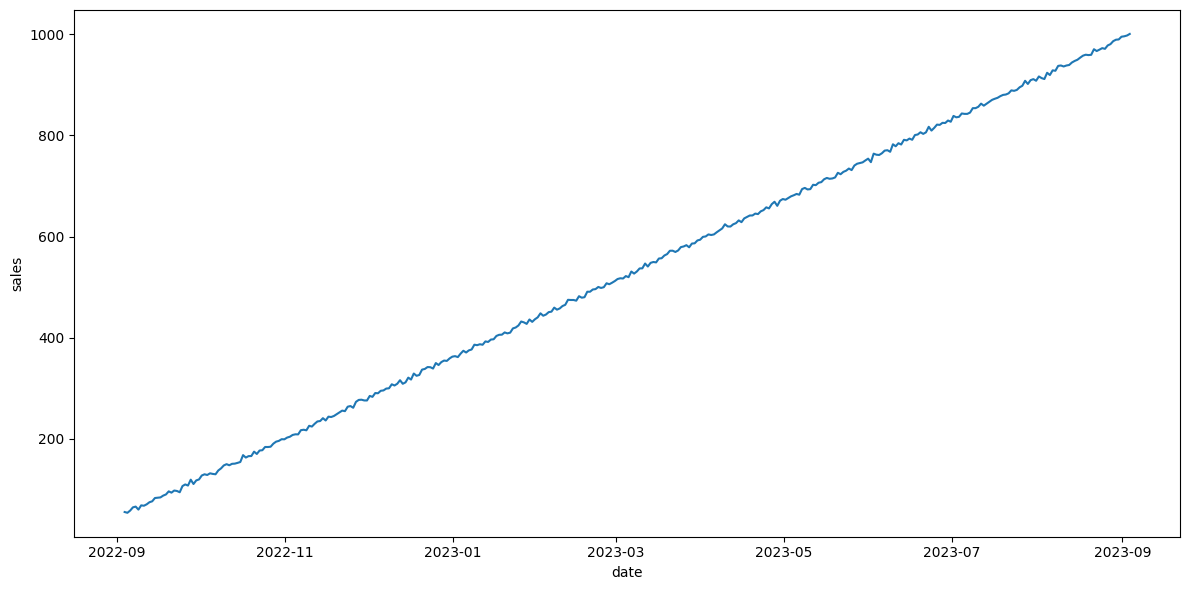

In [30]:
fig, axis = plt.subplots(figsize = (12, 6))
sns.lineplot(data = newData)
plt.tight_layout()
plt.show()

### Descomposición

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(newData, period = 12)
decomposition

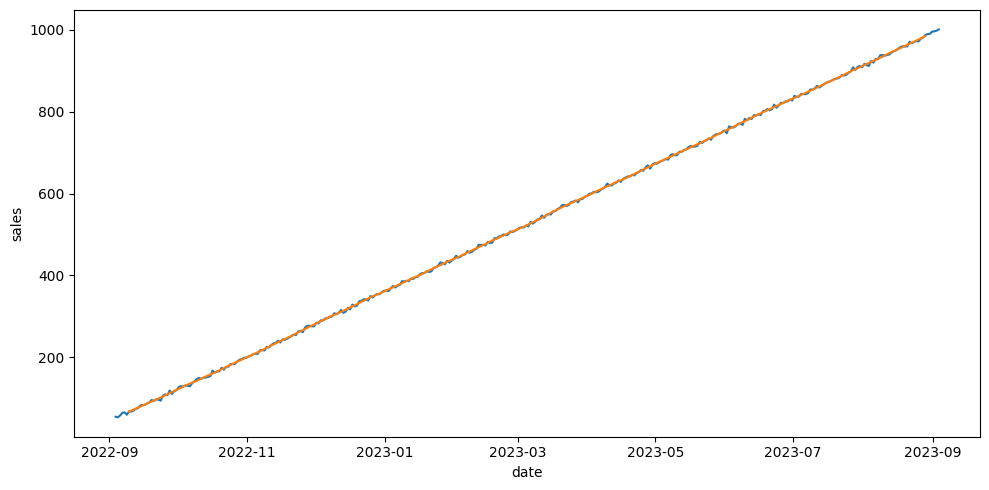

In [32]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = newData)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Tendencia alcista, según avanza el tiempo aumentan las ventas

### Análisis de la estacionalidad

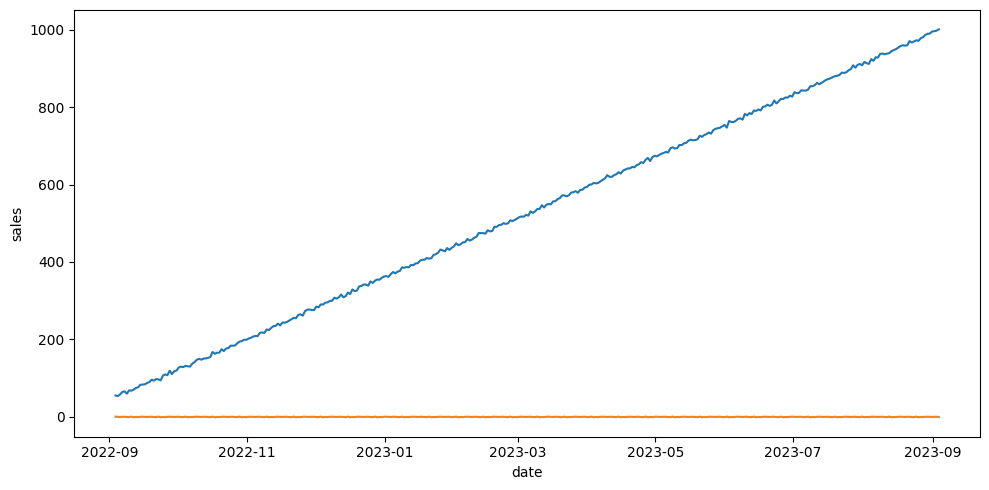

In [33]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = newData)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

#### Dickey-Fuller test

In [34]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(newData)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

`p-value` > 0.05, implica que la hipótesis nula será descartada y se entiende la serie como no estacionaria

### Análisis de variabilidad

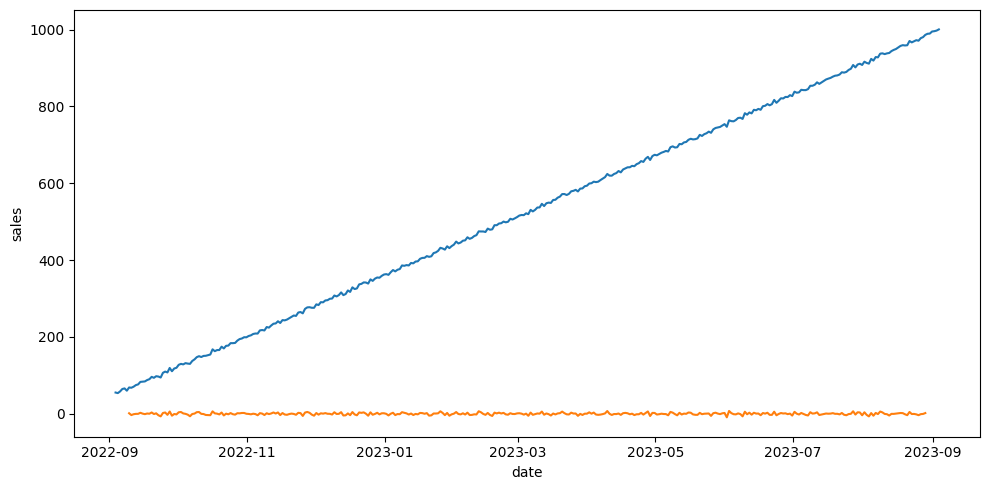

In [35]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = newData)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Aunque los residuos muestran cierta variabilidad, esta es aleatoria y de pequeña magnitud comparada con la tendencia general. No hay indicios de estacionalidad ni de patrones estructurados

### Análisis de la autocorrelación

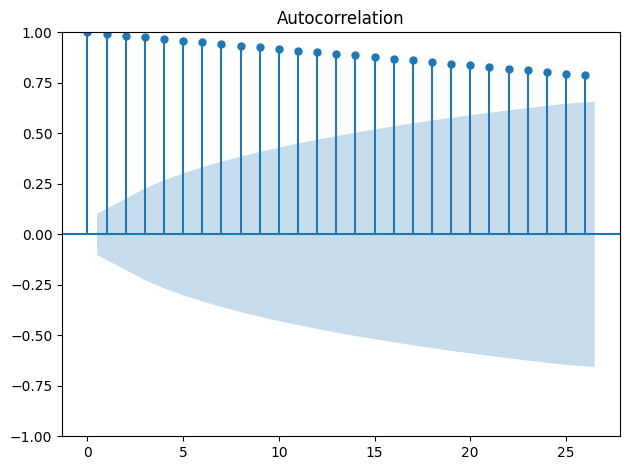

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(newData)

plt.tight_layout()

plt.show()

Según se avanza, disminuye la autocorrelación

## Paso 3: entrena un ARIMA

In [37]:
ts_stationary = newData.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [44]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
model.summary()

## Paso 4: Predice con el conjunto de test

In [ ]:
forecast = model.predict(10)
forecast

In [ ]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

## Paso 5: Guardar el modelo

In [ ]:
with open("../models/arima_sales_predictor_model.pkl", "wb") as file:
  pickle.dump(model, file)